## Imports and configuration
Nothing exciting happening here.

In [214]:
%matplotlib inline

from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import itertools
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import random

# Network initialization
In this part of the notebook, we set up the social network for our simulation.

### Friend group creation
Like real life, this social network has bunches of friends, probably connected by some common interest (school, work, hobby, etc.). In this example, all people in a group are friends with each other.

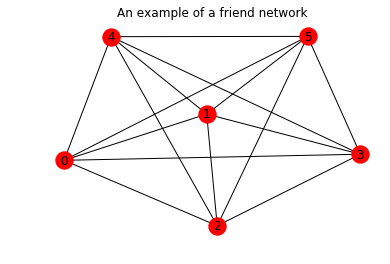

In [215]:
friend_group_count = 3
friends_per_group = 6
max_interminglings = 3

class Person(object):
    def __init__(self, id_number):
        self.id_number = id_number
        # https://homepage.stat.uiowa.edu/~mbognar/applets/normal.html
        self.gullibility = np.random.normal(loc=0.5, scale=0.1) # mean=loc,stdev=scale
        self.hostility = np.random.normal(loc=0.5, scale=0.05)
        self.activity_level = np.random.chisquare(3) / 10
        self.feed = list()
    def __str__(self):
        return str(self.id_number)

friend_groups = list()
friend_networks = list()
all_people = list()

for group_number in range(friend_group_count):
    """
    Initialize groups of friends
    """
    
    # Create a list of friends
    lower_fence = group_number * friends_per_group
    upper_fence = lower_fence + friends_per_group
    friend_group = [Person(id_number) for id_number in range(lower_fence, upper_fence)]
    friend_groups.append(friend_group)
    
    # Create a network from the list
    friend_network = nx.Graph()
    friend_network.add_nodes_from(friend_group)
    friend_networks.append(friend_network)
    
    # Join all the members of the network together
    for friend in friend_network:
        for other_friend in friend_network:
            if other_friend is not friend:
                friend_network.add_edge(friend, other_friend)

for group in friend_groups:
    for person in group:
        all_people.append(person)

plt.title('An example of a friend network')
nx.draw(friend_networks[0], with_labels=True)

### Overall network creation
Now, merge all the friend groups into one big social network, and add some random connections between them.

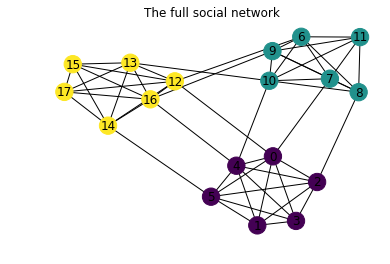

In [216]:
social_network = nx.Graph()

for friend_network in friend_networks:
    social_network.add_nodes_from(friend_network)
    social_network.add_edges_from(friend_network.edges())

for combination in itertools.combinations(friend_networks, r=2):
    fst = list(combination[0].nodes())
    snd = list(combination[1].nodes())
    for _ in range(max_interminglings):
        partner_fst = random.choice(fst)
        partner_snd = random.choice(snd)
        social_network.add_edge(partner_fst, partner_snd)

group_color_map = list()
for index, group in enumerate(friend_groups):
    for _ in range(len(group)):
        group_color_map.append(index / len(friend_groups))

plt.title('The full social network')
nx.draw(social_network, with_labels=True, node_color=group_color_map)

#### Hostility network map
This is an alternate visualization of the network, with colors signifying the individual node's hostility towards Elbonians instead of their group affiliation.

0:	0.5344522800857727
1:	0.4416810544953532
2:	0.4476408267972143
3:	0.4972543463530461
4:	0.47369800523239014
5:	0.5426485093062974
6:	0.4600097443777935
7:	0.5762022956974069
8:	0.43610407952276775
9:	0.48907756968723104
10:	0.41015795646100095
11:	0.45731649985710304
12:	0.44891761337513725
13:	0.4813144737630632
14:	0.4913644551457332
15:	0.4727226737785426
16:	0.4446779185693559
17:	0.4321012738204732


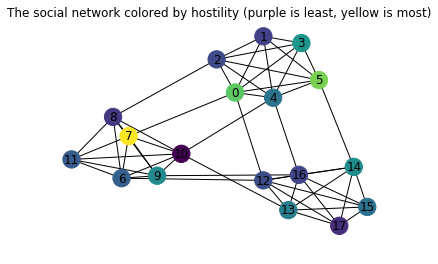

In [221]:
hostility_color_map = list()
for group in friend_groups:
    for friend in group:
        hostility_color_map.append(friend.hostility)
        print('{}:\t{}'.format(friend.id_number, friend.hostility))

plt.title('The social network colored by hostility (purple is least, yellow is most)')
nx.draw(social_network, with_labels=True, node_color=hostility_color_map)

## Simulation
This is the part of the notebook that actually runs the simulation of the social network.

In [218]:
simulation_step_count = 100

data = dict()
for group in friend_groups:
    for person in group:
        data[person.id_number] = {
            'feed_length': list(),
            'hostility': list(),
        }
        person.feed = list()

for step in range(simulation_step_count):
    for group in friend_groups:
        for person in group:
            if random.random() < person.activity_level:
                person.feed.append('bleep bloop')
            data[person.id_number]['feed_length'].append(len(person.feed))
            data[person.id_number]['hostility'].append(person.hostility)

### Visualizations of simulation results

In [219]:
def draw_activity_level(id_number):
    person = all_people[id_number]
    plt.title('Activity level: ' + str(person.activity_level))
    plt.ylabel('Number of posts')
    plt.xlabel('Simulation step number')
    plt.plot(data[person.id_number]['feed_length'])
    plt.show()

def draw_hostility_plot(id_number):
    person = all_people[id_number]
    plt.title('Hostility')
    plt.ylim(0, 1)
    plt.ylabel('Hostility (0-1)')
    plt.xlabel('Simulation step number')
    plt.plot(data[person.id_number]['hostility'])
    plt.show()

interact(draw_activity_level, id_number=(0, len(all_people) - 1))
interact(draw_hostility_plot, id_number=(0, len(all_people) - 1))

<function __main__.draw_hostility_plot>